# 14.3 用于预训练词嵌入的数据集
- **目录**
  - 14.3.1 读取词嵌入数据集
  - 14.3.2 词嵌入数据集下采样
  - 14.3.3 中心词和上下文词的提取
  - 14.3.4 词嵌入负采样
  - 14.3.5 小批量加载词嵌入训练数据实例
  - 14.3.6 整合词嵌入数据集代码

- 现在已经了解了word2vec模型的技术细节和大致的训练方法，让我们来看看它们的实现。
  - 具体地说，本节将以14.1节的跳元模型和14.2节的负采样为例。
- 本节从用于预训练词嵌入模型的数据集开始：数据的原始格式将被转换为可以在训练期间迭代的小批量。
- 本节的函数与API列表：
  - read_ptb：读取PTB数据集。
  - subsample：下采样。
  - show_list_len_pair_hist：绘制了下采样前后每句话的词元数量的直方图。
  - compare_counts：比较下采样前后的某个词元的词频。
  - get_centers_and_contexts：获取“中心词-上下文词”对。
  - RandomGenerator：对噪声词进行随机采样。
  - get_negatives：返回负采样的噪声词（或负样本，二者表示相同对象，即通过负采样得到的词）。
  - batchify：返回带有负采样的跳元模型的小批量样本。
  - load_data_ptb：下载PTB数据集，然后将其加载到内存中。

In [34]:
%matplotlib inline
import math
import os
import random
import torch
from d2l import torch as d2l

-------
- **说明：如果发生Unable to retrieve source for @torch.jit._overload function警告**
  - 则修改此文件“F:\Users\hp\AppData\Local\Programs\Python\Python310\Lib\site-packages\torch\_jit_internal.py”
  <center><img src='../img/14_3_1.png'></center>
  - 该警告不影响运行，只是有点影响观感。
--------

## 14.3.1 读取词嵌入数据集
- 此处使用的数据集是[Penn Tree Bank（PTB）](https://catalog.ldc.upenn.edu/LDC99T42)。
- 该语料库取自“华尔街日报”的文章，分为**训练集**、**验证集**和**测试集**。
- 在原始格式中，文本文件的每一行表示由空格分隔的一句话。在这里，我们将每个单词视为一个词元。


In [35]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Read the training set.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

In [36]:
type(sentences),sentences[:2]

(list,
 [['aer',
   'banknote',
   'berlitz',
   'calloway',
   'centrust',
   'cluett',
   'fromstein',
   'gitano',
   'guterman',
   'hydro-quebec',
   'ipo',
   'kia',
   'memotec',
   'mlx',
   'nahb',
   'punts',
   'rake',
   'regatta',
   'rubens',
   'sim',
   'snack-food',
   'ssangyong',
   'swapo',
   'wachter'],
  ['pierre',
   '<unk>',
   'N',
   'years',
   'old',
   'will',
   'join',
   'the',
   'board',
   'as',
   'a',
   'nonexecutive',
   'director',
   'nov.',
   'N']])

- 在读取训练集之后，再为语料库构建了一个词表，其中出现次数少于10次的任何单词都将由“&lt;unk&gt;”词元替换。
- 请注意，原始数据集还包含表示稀有（未知）单词的“&lt;unk&gt;”词元。


In [37]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [38]:
vocab.idx_to_token[10],vocab.token_to_idx['for']

('for', 10)

## 14.3.2 词嵌入数据集下采样

- 文本数据通常有“the”、“a”和“in”等高频词：这些词在非常大的语料库中甚至可能出现数十亿次。
- 然而，这些词经常在上下文窗口中与许多不同的词共同出现，**提供的有用信息很少**。
  - 例如，考虑上下文窗口中的词“chip”：直观地说，它与低频单词“intel”的共现比与高频单词“a”的共现在训练中更有用。
  - 此外，**大量（高频）单词导致模型的训练速度放慢**。
- 因此，当训练词嵌入模型时，可以对高频单词进行**下采样**。具体地说，数据集中的每个词$w_i$将有概率地被丢弃
$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),\tag{13.4.1}$$
  - 其中$f(w_i)$是$w_i$的词数与数据集中的总词数的比率，常量$t$是超参数（在实验中为$10^{-4}$）。我们可以看到，只有当相对比率$f(w_i) > t$时，（高频）词$w_i$才能被丢弃，且该词的相对比率越高，被丢弃的概率就越大。


------
- **说明：如何理解公式$13.4.1$ ?**
  - 公式公式$13.4.1$ 用于下采样高频词。这种下采样策略是在词嵌入中为了减少训练的计算开销和改善词嵌入质量而采用的。
  - **为什么下采样高频词？**
    - 在文本数据中，某些高频词（如 "the"、"is"）提供的语义信息相对较少。
    - **由于它们几乎在每个上下文中都出现，所以它们对于特定的语义关系的建模贡献不大**。
    - 通过下采样这些词，我们可以减少训练的计算负担，并更加关注**对模型更有意义的低频词**。
  - **如何理解$f(w_i)$ ?**
    - $f(w_i)$是词$w_i$的词频与数据集中的总词数的比例。这给出了一个词在文本中的相对频率。
    - 例如，如果 "the" 出现了 1000 次，而总词数是 10000，那么$f(\text{"the"}) = 0.1$。
  - **为什么使用$\sqrt{\frac{t}{f(w_i)}}$ ?**
    - 这个公式的设计是为了**在词频$f(w_i)$增加时增加丢弃概率**。
    - 常数$t$是一个阈值，决定哪些词有可能被下采样。
    - 当$f(w_i)$小于$t$时，其丢弃概率接近于 0。而当$f(w_i)$远大于$t$时，丢弃概率接近于 1。
  - **为什么有$\max$函数？**
    - $\max$函数确保丢弃概率不会为负。这是为了处理那些频率非常低的词，因为在这些情况下，公式可能会给出负的概率值。
- **示例：从下图可以看到随着词频的增加，其下采样概率也逐渐增加**

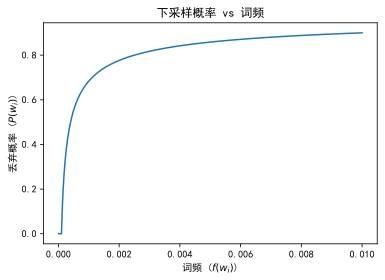

In [39]:
# Python示例进一步理解：
import numpy as np
import matplotlib.pyplot as plt

# 定义下采样概率函数
def subsampling_prob(f_wi, t=1e-4):
    return max(1 - np.sqrt(t / f_wi), 0)

# 生成模拟的词频数据
frequencies = np.linspace(1e-5, 1e-2, 1000)  # 模拟从非常低频到较高频的单词

# 计算丢弃概率
drop_probs = [subsampling_prob(f) for f in frequencies]

# 绘图
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用'SimHei'字体（黑体）
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.figure(figsize=(6, 4))
plt.plot(frequencies, drop_probs)
plt.xlabel('词频 ($f(w_i)$)')
plt.ylabel('丢弃概率 ($P(w_i)$)')
plt.title('下采样概率 vs 词频')
plt.show()


--------

In [40]:
#@save
def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        '''
        keep函数并没有计算丢弃概率。
        相反，它比较一个随机数与下采样阈值。
        如果随机数小于这个阈值，就保留这个词。
        虽然这种方法并不直接计算丢弃概率，
        但它仍然实现了与公式中描述的下采样策略相似的目的：高频词被丢弃的概率会更高。
        也就是说：词抛弃是概率，并不是根据公式和阈值硬性规定的。
        '''
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

In [41]:
# 词频字典
counter['the'], counter['john']

(50770, 263)

In [42]:
vocab['john']

399

In [43]:
len(subsampled),subsampled[:10]

(42069,
 [[],
  ['years', 'old', 'join', 'as', 'director'],
  ['mr.', 'n.v.', 'dutch', 'publishing'],
  ['years',
   'old',
   'consolidated',
   'gold',
   'fields',
   'plc',
   'a',
   'director',
   'british',
   'conglomerate'],
  ['form',
   'asbestos',
   'once',
   'kent',
   'cigarette',
   'filters',
   'caused',
   'percentage',
   'cancer',
   'deaths',
   'workers',
   'exposed',
   'than',
   'years',
   'ago',
   'researchers'],
  ['asbestos',
   'unusually',
   'once',
   'brief',
   'causing',
   'symptoms',
   'show',
   'up',
   'decades',
   'researchers'],
  ['inc.',
   'new',
   'york-based',
   'that',
   'makes',
   'kent',
   'cigarettes',
   'stopped',
   'using',
   'cigarette',
   'filters'],
  ['although',
   'preliminary',
   'findings',
   'ago',
   'latest',
   'results',
   'appear',
   'england',
   'journal',
   'medicine',
   'likely',
   'bring',
   'attention',
   'problem'],
  ['story'],
  ['we',
   'talking',
   'anyone',
   'heard',
   'asbestos

In [44]:
#d2l.count_corpus??

- 下面的代码片段绘制了下采样前后每句话的词元数量的直方图。
- 正如预期的那样，**下采样通过删除高频词来显著缩短句子**，这将使训练加速。


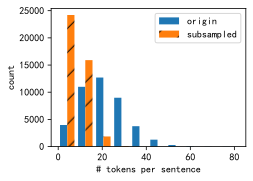

In [45]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled);

- 对于单个词元，高频词“the”的采样率不到1/20。

In [46]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'"the"的数量：之前=50770, 之后=2005'

- 相比之下，低频词“join”则被完全保留。


In [47]:
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

- 在下采样之后，我们将词元映射到它们在语料库中的索引。

In [48]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [71, 392, 2115, 18, 274], [22, 5277, 3054, 1580]]

## 14.3.3 中心词和上下文词的提取

- 下面的`get_centers_and_contexts`函数从`corpus`中提取所有中心词及其上下文词。
- 它随机采样1到`max_window_size`之间的整数作为上下文窗口。
- 对于任一中心词，与其距离不超过采样上下文窗口大小的词为其上下文词。


In [49]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            ## 窗口大小是从1到max_window_size之间的一个随机整数
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

- 接下来创建一个人工数据集，分别包含7个和3个单词的两个句子。
- 设置最大上下文窗口大小为2，并打印所有中心词及其上下文词。


In [50]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1]
中心词 1 的上下文词是 [0, 2]
中心词 2 的上下文词是 [0, 1, 3, 4]
中心词 3 的上下文词是 [2, 4]
中心词 4 的上下文词是 [2, 3, 5, 6]
中心词 5 的上下文词是 [3, 4, 6]
中心词 6 的上下文词是 [5]
中心词 7 的上下文词是 [8]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [7, 8]


In [51]:
## 直接调用，第一个list是中心词列表，第二个嵌套列表是各个中心词的上下文词
get_centers_and_contexts(tiny_dataset, 2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [[1],
  [0, 2, 3],
  [1, 3],
  [2, 4],
  [2, 3, 5, 6],
  [3, 4, 6],
  [5],
  [8],
  [7, 9],
  [8]])

- 在PTB数据集上进行训练时，此处将最大上下文窗口大小设置为5。
- 下面提取数据集中的所有中心词及其上下文词。


In [52]:
## 注意：此处“中心词-上下文词对”并不是数据的条数
## 中心词的个数才和数据条数一致的，本节末尾可以看到数据大概34万条左右
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

'# “中心词-上下文词对”的数量: 1497470'

## 14.3.4 词嵌入负采样

- 此处使用负采样进行近似训练。
- 为了根据预定义的分布对噪声词进行采样，定义以下`RandomGenerator`类，其中（可能未规范化的）采样分布通过变量`sampling_weights`传递。

In [53]:
#@save
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

- RandomGenerator详细注释

In [54]:
'''
预生成负采样的词元索引，减少random.choices的调用次数。
通过空间换时间（缓存），解决高频采样时的性能瓶颈。
'''
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        '''
        索引总体 [1, 2, ..., n]，n为权重列表长度。
        population属性保存的索引值是由权重列表的长度生成。
        注意索引列表起始是1而不是0,是为排除掉词表中的第一个词元<unk>，即未知词元，
        也是为了和权重对齐。
        '''
        self.population = list(range(1, len(sampling_weights) + 1))
        '''
        sampling_weights是负采样词元的权重。
        根据后面的代码，权重值是每个词元的词频的3/4次方。
        该权重在后面代码中调用choices方法时作为随机抽取噪声词的概率计算依据。
        '''
        self.sampling_weights = sampling_weights
        '''
        缓存从 population 中按权重抽样的结果（存储索引值）。
        '''
        self.candidates = []
        '''
        i是从candidates缓存中抽取噪声词索引时的标记，类似数据库的游标，
        表示上次负采样后的candidates所在位置，本次负采样返回i当前位置的噪声词，
        然后+1，将游标往后移动一个单元。
        当i等于candidates的长度(本类该缓存长度为10000)时，
        表示candidates缓存的噪声词已经全部被使抽取过，需要生成新candidates缓存了。
        '''
        self.i = 0

    def draw(self):
        '''
        当i等于candidates的长度(此处为10000)时，表示candidates缓存的噪声词
        已经全部被抽取过，需要生成新candidates缓存了。
        '''
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            '''
            按照权重随机抽取噪声词的索引缓存。注意choices方法的用法。
            每次生成缓存为10000个样本索引。
            choices方法第一个参数是被采样的对象，第二个参数是权重，k表示采样的样本数量。
            random.choices方法是有放回抽样。
            '''
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            # 重新生成缓存之后将游标标记重新设置为0，即从头开始从缓存中返回噪声词索引
            self.i = 0
        # 将游标往后移动一个单元，注意：draw方法将返回当前位置即移动前所在位置的负采样索引
        self.i += 1
        return self.candidates[self.i - 1] # 注意此处将i-1，即移动前位置保存的候选噪声词索引

In [55]:
#random.choices?

- 例如可以在索引1、2和3中绘制10个随机变量$X$，采样概率为$P(X=1)=2/9, P(X=2)=3/9$和$P(X=3)=4/9$，如下所示。

In [56]:
#@save
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 3, 3, 1, 1, 2, 1, 3, 1, 2]

- 对于一对中心词和上下文词，我们随机抽取了`K`个（实验中为5个）噪声词。
- 根据word2vec论文中的建议，将噪声词$w$的采样概率$P(w)$设置为其在字典中的相对频率，其幂为0.75。

In [57]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

- get_negatives详细注释

In [58]:
'''
为每个中心词的所有上下文词的条件概率计算获取负采样噪声词。
可参考14.2节的公式14.2.5和14.2.6。
根据上述两个公式，每个中心词元有2m个上下文词，m为窗口大小；
每个上下文词与中心词计算条件概率时，
有k个噪声词参与条件概率与负对数损失函数的计算。
all_contexts是一个嵌套列表，每个子列表保存每个中心词所对应的所有上下文词。
注意根据前述中心词上下文词对获取函数get_centers_and_contexts的算法，
每个中心词的上下文词的数量是一个随机数，即从1到max_window_size之间随机生成的一个整数。
因此对于所有中心词来说，最终生成负采样的数量也是不同的。
'''
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    '''
    从词表中取出除了<unk>未知标记之外的所有词元，然后计算每个词元的词频，并计算词频的0.75次方。
    基本步骤：从词表中取出词元索引，通过索引提取词元，根据词元在文本序列或语料数据中统计词频，
    最后计算词频的0.75次方，最后保存在列表中。
    '''
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    '''
    初始化保存所有负采样的变量all_negatives，是一个列表，而且最终是一个嵌套列表。
    每个子列表保存某个中心词所有上下文词各自对应的负采样。
    生成RandomGenerator对象generator，用于负采样。
    '''
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    '''
    根据上下文词获取噪声词。
    all_contexts是一个嵌套列表，其子列表保存每个中心词的上下文词。
    contexts是保存某个中心词的上下文词(每个子列表最多有2m个上下文词)的列表。
    '''
    for contexts in all_contexts:
        '''
        初始化负采样列表，保存某个中心词所对应的所有上下文词的噪声词。
        按照顺序每个上下文词对应K个噪声词，一共有len(contexts) * K个噪声词。
        '''
        negatives = []
        '''
        negatives的长度等于某个中心词对应的上下文词个数乘以K。
        其含义为每个上下文词抽取K个噪声词。
        注意噪声词不能是该中心词的上下文词。
        
        '''
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        # 将某个中心词的所有上下文词对应的全部噪声词作为一个列表添加到all_negatives
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [59]:
# all_negatives是一个嵌套列表，子列表存储每个中心词-上下文词对的噪声词索引
all_negatives[:3]

[[653, 741, 747, 70, 1442],
 [30, 833, 297, 46, 1053, 1036, 84, 317, 597, 716],
 [239,
  4754,
  56,
  1272,
  1525,
  725,
  1042,
  2769,
  1126,
  4209,
  724,
  481,
  394,
  4787,
  23,
  117,
  1631,
  622,
  2440,
  1515]]

In [60]:
# 每个中心词的上下文词个数不完全相同
all_contexts[:12]

[[392],
 [71, 2115],
 [71, 392, 18, 274],
 [71, 392, 2115, 274],
 [392, 2115, 18],
 [5277],
 [22, 3054],
 [22, 5277, 1580],
 [22, 5277, 3054],
 [392],
 [71, 2467, 656, 2157, 948],
 [71, 392, 656, 2157, 948, 5]]

In [61]:
## 比如索引为7的中心词的上下文词有3个，噪声词就有3*5=15个
all_contexts[7], len(all_negatives[7])

([22, 5277, 1580], 15)

## 14.3.5 小批量加载词嵌入训练数据实例
- 在提取所有中心词及其上下文词和采样噪声词后，将它们转换成小批量的样本，在训练过程中可以迭代加载。
- 在小批量中，$i^\mathrm{th}$个样本包括中心词及其$n_i$个上下文词和$m_i$个噪声词。
  - 由于上下文窗口大小不同，$n_i+m_i$对于不同的$i$是不同的。
  - 因此，对于每个样本，我们在`contexts_negatives`个变量中**将其上下文词和噪声词连结起来，并填充零**，直到连结长度达到$\max_i n_i+m_i$(`max_len`)。
- 为了在计算损失时排除填充，我们定义了掩码变量`masks`。
  - 在`masks`中的元素和`contexts_negatives`中的元素之间存在一一对应关系，其中`masks`中的0（否则为1）对应于`contexts_negatives`中的填充。
- 为了区分正反例，我们在`contexts_negatives`中通过一个`labels`变量将上下文词与噪声词分开。
  - 类似于`masks`，在`labels`中的元素和`contexts_negatives`中的元素之间也存在一一对应关系，其中`labels`中的1（否则为0）对应于`contexts_negatives`中的上下文词的正例（正例其实就是上下文词本身，反例就是负样本即噪声词）。
- 上述思想在下面的`batchify`函数中实现。
  - 其输入`data`是长度等于批量大小的列表，其中每个元素是由中心词`center`、其上下文词`context`和其噪声词`negative`组成的样本。
  - 此函数返回一个可以在训练期间加载用于计算的小批量，例如包括掩码变量。


In [62]:
#@save
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

- batchify详细注释

In [63]:
'''
对中心词、上下文词、噪声词等数据进行批量化处理。
以下述示例中的x_1：(1, [2, 2], [3, 3, 3, 3])为例，data参数的各个部分分别表示：
(1)第一个元素 1：中心词在词汇表中的索引（例如词汇表中 1 可能对应单词 "apple"）。
(2)第二个元素 [2, 2]：该中心词的上下文词索引列表（例如 2 可能对应 "fruit"，重复表示多次共现）。
(3)第三个元素 [3, 3, 3, 3]：负采样得到的噪声词索引列表（例如 3 可能对应无关词 "car"）。

'''
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    '''
    取出上下文词列表的最大长度和噪声词列表的最大长度，然后将二者相加。
    data的第一个元素是中心词索引。
    然后通过上下文词列表的最大长度和噪声词列表的最大长度之和获得最大长度max_len，
    该变量用于形成批量数据中向量的最大长度，达不到该最大长度则填充0.
    '''
    max_len = max(len(c) + len(n) for _, c, n in data)
    # 初始化中心词、上下文-噪声词(负样本)对，掩码以及标签列表
    centers, contexts_negatives, masks, labels = [], [], [], []
    # 取出每个中心词、中心词所对应的上下文词以及上下文词所对应的噪声词
    for center, context, negative in data:
        cur_len = len(context) + len(negative)# 上下文词列表与对应噪声词列表的实际长度之和
        # 在每条样本数据中，中心词索引是一个标量，将其拼接成一个列表，后面还要将其转换成列向量
        centers += [center]
        '''
        将上下文词列表和中心词列表拼接成一个列表。
        如何拼接后的列表长度小于max_len，后面不足的部分则填充为0.
        '''
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        '''
        掩码用于区分拼接列表中的有效索引和填充。
        1表示有效词索引（上下文词与噪声词索引），0表示填充。
        '''
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        '''
        标签列表用于区分列表中的上下文词与噪声词。
        1表示上下文词；0表示其他(噪声词与填充都使用0标记)。
        注意labels也是一个嵌套列表，每个子列表表示某个中心词的上下文词。
        注意此处+=的用法，仍然是列表的拼接，此处是将列表中的子列表拼接成一个嵌套列表。
        '''
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    '''
    将上述变量全部转换成张量类型。
    centers中心词索引转换成列向量，也是一个二维数组，只不过列数等于1。
    contexts_negatives上下文词-噪声词索引转换成二维数组，列数等于max_len。
    masks和labels都是二维数组，列数等于max_len。
    上述各张量的行数皆等于数据的条数，即批量大小。
    下述示例中使用tuple的元素表示一条数据。
    '''    
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [64]:
## max的用法
data = ([1,[2,3],[4,5,6,7]],[2,[3,4,5],[1,2,3,4,5,6]])
max(len(a)+len(b) for _, a,b in data)

9

- 现在使用一个小批量的两个样本来测试此函数。

In [65]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


## 14.3.6 整合词嵌入数据集代码

- 最后定义了读取PTB数据集并返回数据迭代器和词表的`load_data_ptb`函数。


In [66]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    
    ## 原代码在windows环境下运行会发生异常，因此将num_workers改为0，则可消除异常
    #num_workers = d2l.get_dataloader_workers()
    num_workers=0
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

- 现在打印数据迭代器的第一个小批量。

In [67]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [75]:
## 实际的数据条数，也就是中心词个数
len(iter(data_iter))*512

343040

In [76]:
'''
下采样后语料库中的词元个数，为何存在差别？
那是因为下采样后有些句子的词元个数小于2，
就不会为该语句中的词元作为中心词来获取上下文词，因此也不会进入数据集。
可参见get_centers_and_contexts方法的代码。
结果显示，有343488 - 343040 = 448条数据的词元个数小于2，因此被排除在数据集之外。
'''
sum(len(line) for line in subsampled)

343488

## 小结

* 高频词在训练中可能不是那么有用。我们可以对他们进行下采样，以便在训练中加快速度。
* 为了提高计算效率，我们以小批量方式加载样本。我们可以定义其他变量来区分填充标记和非填充标记，以及正例和负例。